# Mass-Spring-Damper System: Generating Training and Test Data

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')



### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
# from PCAfold         import PCA          as PCAA

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
OutputDir   = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/MSD_100Cases/')
FigDir      = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')

n_training  = 100
n_test      = 10  

Nt          = 500
tout        = np.linspace(0.,15.,Nt)
SOLVER      = 'Radau'

MinVals     = [-4., -4.]
MaxVals     = [4., 4.]


ColorVec    = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

OutputDir += '/Orig/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

TempDir = OutputDir+'/train/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = OutputDir+'/test/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

## ODE

In [3]:
def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Jacobian(t, y):

    Eps = 1e-6
    J   = np.zeros([len(y), len(y)], dtype = np.float)

    for i in range(len(y)):
        y1 = y.copy()
        y2 = y.copy()

        y1[i] += Eps
        y2[i] -= Eps

        f1 = np.array(fOrig(t, y1))
        f2 = np.array(fOrig(t, y2))

        J[ : , i] = (f1 - f2) / (2. * Eps)

    return J

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

## Sampling and Plotting Initial Conditions

In [4]:
### From Uniform Distibutions

# y0Mat      = np.zeros((n_training,2))
# y0Mat[:,0] = np.random.rand(n_training)*4. - 2.0
# y0Mat[:,1] = np.random.rand(n_training)*4. - 2.0

# y0MatTest      = np.zeros((n_test,2))
# y0MatTest[:,0] = np.random.rand(n_test)*4. - 2.0
# y0MatTest[:,1] = np.random.rand(n_test)*2. - 1.0


### From Latin Hypercube 

y0Mat     = pyDOE.lhs(2, samples=n_training, criterion='center')
for i in range(2):
    y0Mat[:,i] = y0Mat[:,i] * (MaxVals[i] - MinVals[i]) + MinVals[i]

y0MatTest     = pyDOE.lhs(2, samples=n_test, criterion='center')
for i in range(2):
    y0MatTest[:,i] = y0MatTest[:,i] * (MaxVals[i] - MinVals[i]) + MinVals[i]

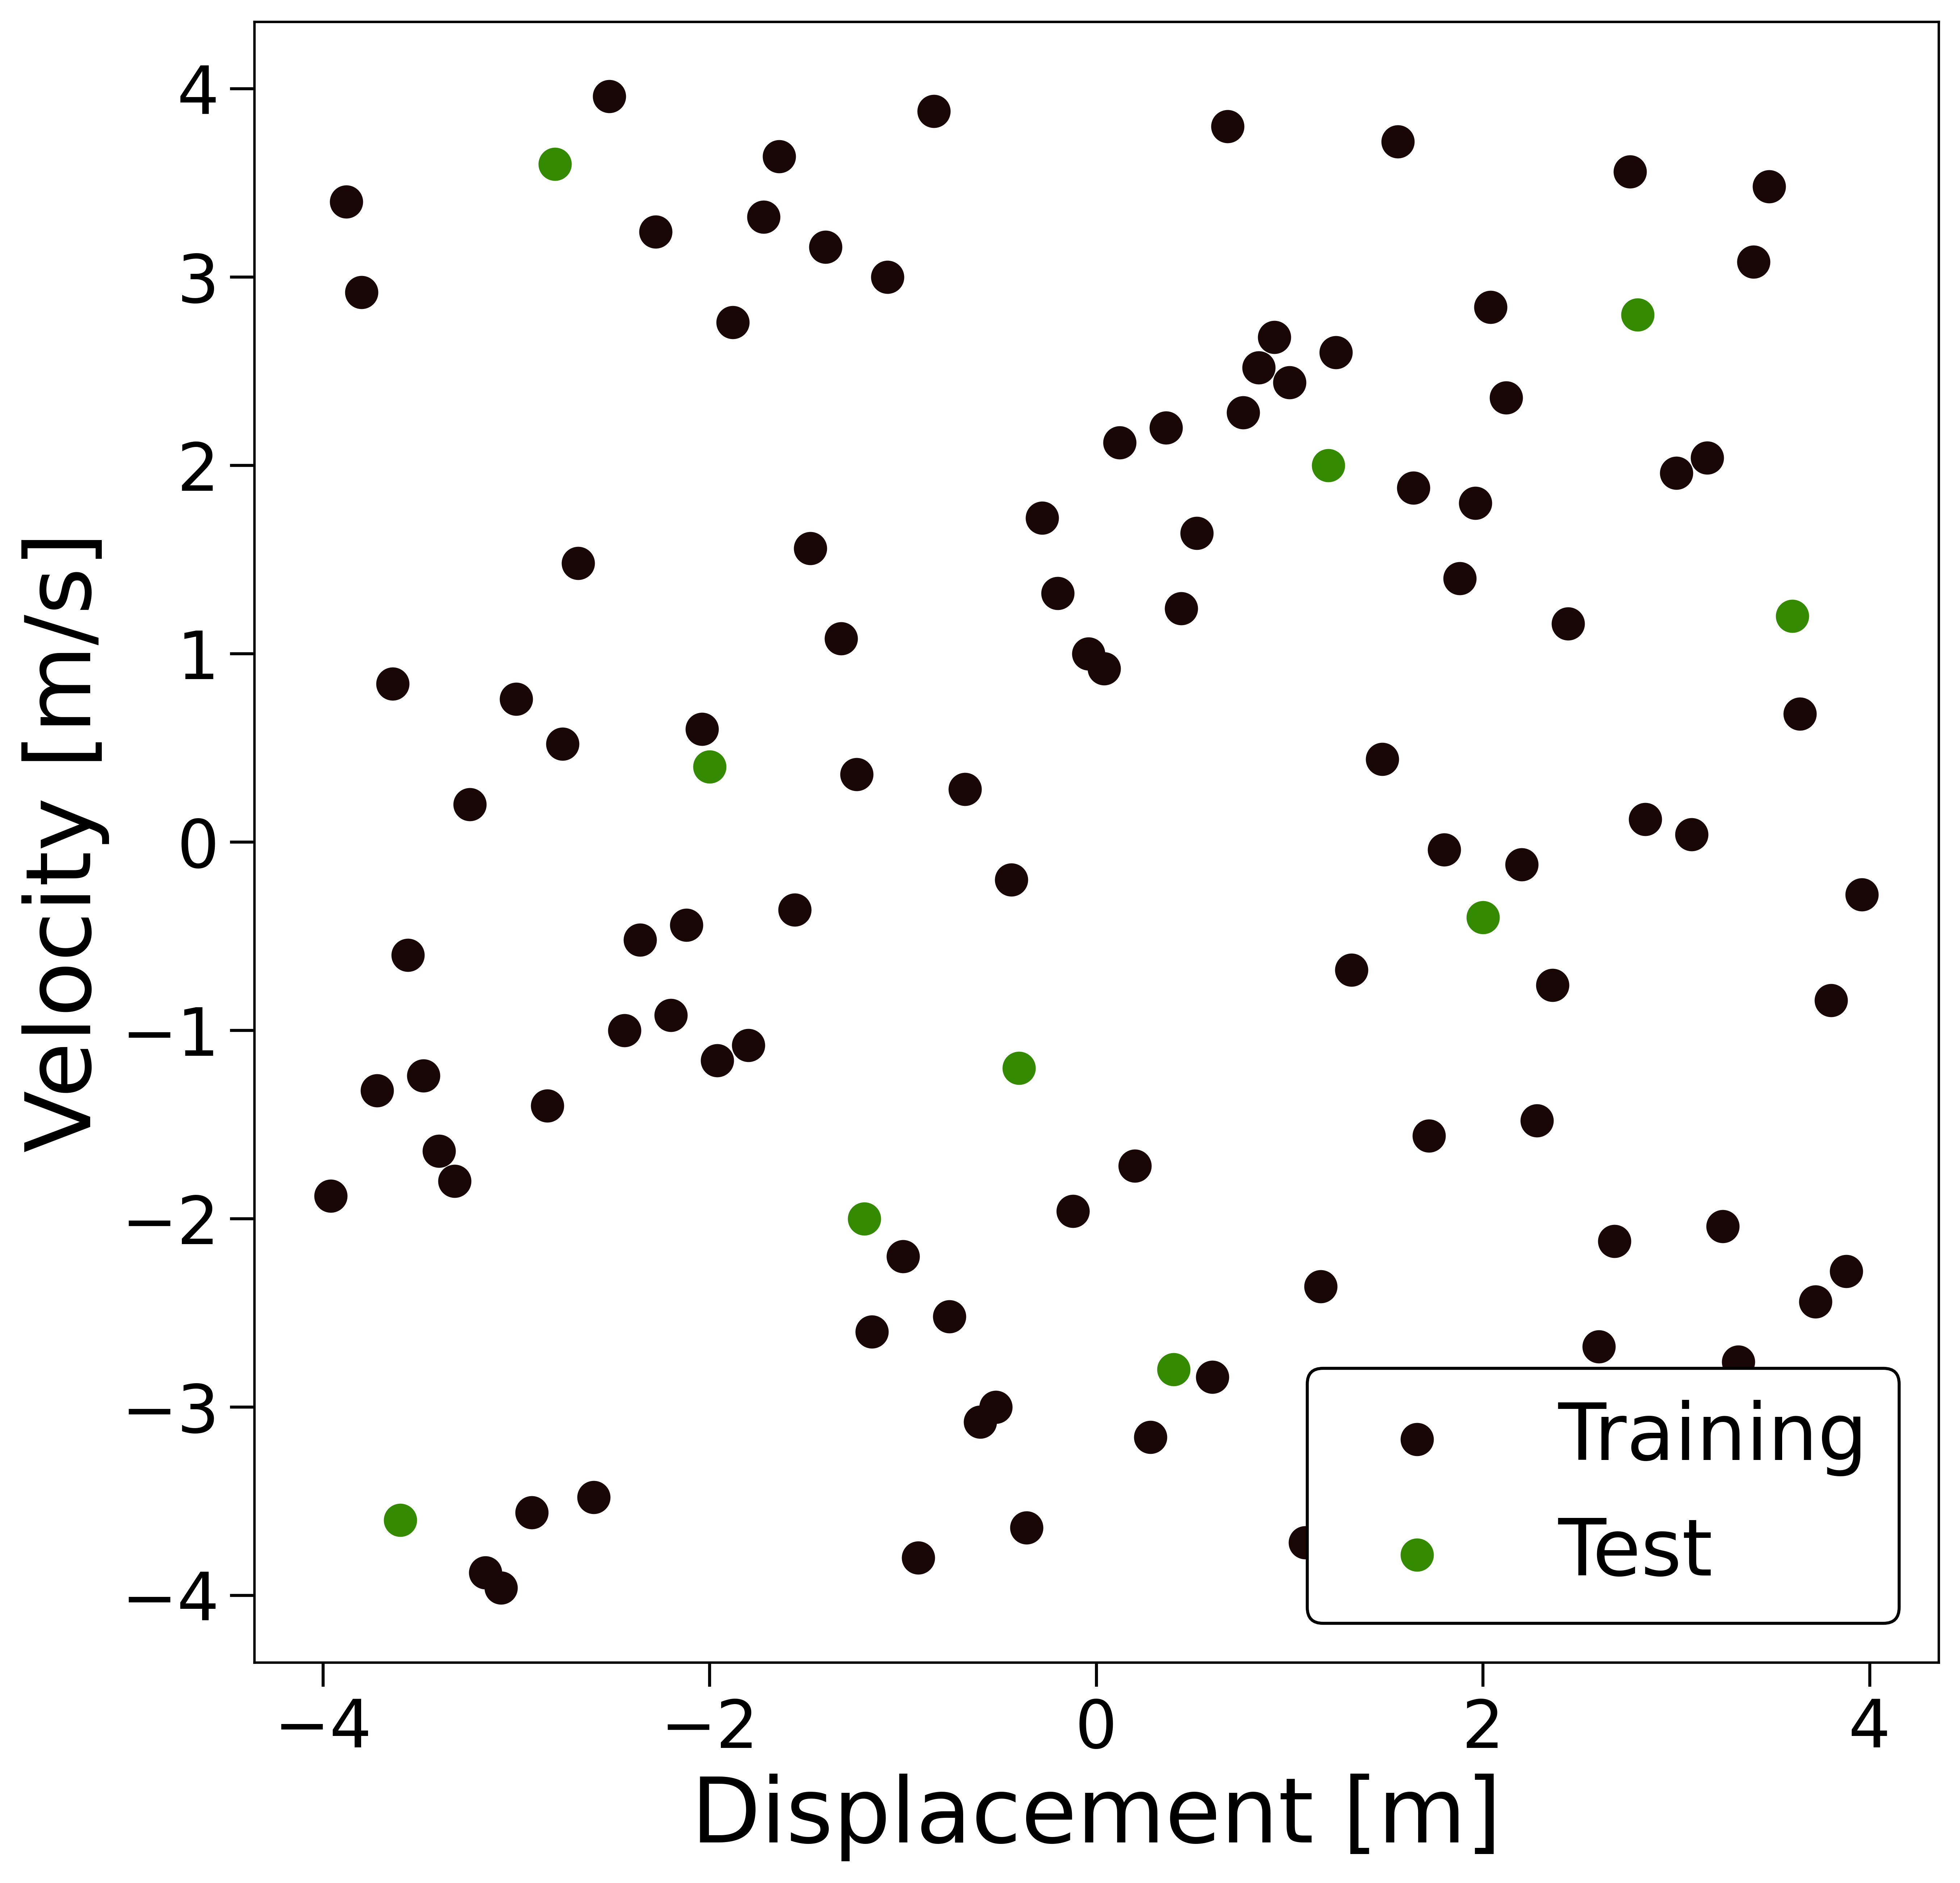

In [5]:
plt.figure()
plt.scatter(y0Mat[:,0],     y0Mat[:,1],                    label='Training')
plt.scatter(y0MatTest[:,0], y0MatTest[:,1], c=ColorVec[3], label='Test')
plt.xlabel('Displacement [m]')
plt.ylabel('Velocity [m/s]')
plt.legend()

if (FigDir):
    plt.savefig(FigDir+'/MSD_ICs.eps', format='eps', bbox_inches='tight')

## Generating Training Data

y0 =  [-2.68  1.48]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.6  -3.48]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.08 -3.72]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 2.6  -2.68]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.24 2.6 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.68  0.28]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.48  1.56]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.04 0.92]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.28  1.72]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 2.28 -1.48]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.04  0.6 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 2.52 -3.4 ]
y0 =  [-1.96 -1.16]
y0 =  [-3.32 -1.8 ]
y0 =  [ 3.96 -0.28]
y0 =  [1.   2.44]
y0 =  [-2.52  3.96]
y0 =  [-3.08 -3.96]
y0 =  [0.76 2.28]
y0 =  [0.84 2.52]
y0 =  [ 2.36 -0.76]
y0 =  [-0.6  -3.08]
y0 =  [ 2.92 -3.32]
y0 =  [ 1.72 -1.56]
y0 =  [0.68 3.8 ]
y0 =  [1.64 1.88]
y0 =  [0.12 2.12]
y0 =  [1.56 3.72]
y0 =  [-1.24  0.36]
y0 =  [-1.08  3.  ]
y0 =  [-0.44 -0.2 ]
y0 =  [0.44 1.24]
y0 =  [-3.96 -1.88]
y0 =  [-3.8   2.92]
y0 =  [-1.72  3.32]
y0 =  [ 0.28 -3.16]
y0 =  [1.88 1.4 ]
y0 =  [0.92 2.68]
y0 =  [-3.24  0.2 ]
y0 =  [2.04 2.84]
y0 =  [-0.2   1.32]
y0 =  [-0.92 -3.8 ]
y0 =  [ 0.6  -2.84]
y0 =  [0.52 1.64]
y0 =  [-3.88  3.4 ]
y0 =  [-1.8  -1.08]
y0 =  [-3.    0.76]
y0 =  [-2.2  -0.92]
y0 =  [-0.52 -3.  ]
y0 =  [-3.56 -0.6 ]
y0 =  [3.   1.96]
y0 =  [ 1.16 -2.36]
y0 =  [ 2.2  -0.12]
y0 =  [ 3.56 -2.92]
y0 =  [-1.4   3.16]
y0 =  [1.48 0.44]
y0 =  [-0.36 -3.64]
y0 =  [3.48 3.48]
y0 =  [-1.88  2.76]
y0 =  [ 1.32 -0.68]
y0 =  [-0.04  1.  ]
y0 =  [-3.16 -3.88]
y0 =  [2.8

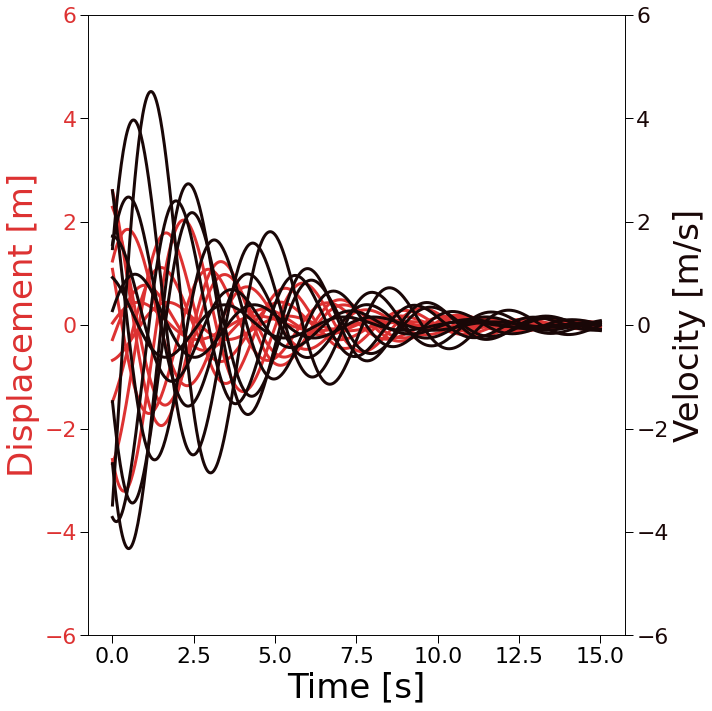

In [6]:
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()  # instantiate a second axes that shares the same x-axis
for iSample in range(n_training):
    y0         = y0Mat[iSample,:]
    print('y0 = ', y0)
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    if (iSample//10 == 0):
        color = ColorVec[1]
        ax1.plot(output.t, output.y[0,:], color=color)

        color = ColorVec[0]
        ax2.plot(output.t, output.y[1,:], color=color)
    
    
    ySourceTemp = np.zeros_like(output.y)
    JJTauMat    = np.zeros((output.y.shape[1], output.y.shape[0]*2))
    for it in range(Nt):
        ySourceTemp[:,it] = fOrig_Source(output.t, output.y[:,it])
        JJ                = fOrig_Jacobian(it, output.y[:,it])        
        JJEig, JJVec      = np.linalg.eig(JJ)
        JJTauMat[it,0:2]  = 1./JJEig.real
        JJTauMat[it,2:4]  = 1./JJEig.imag

    if (iSample == 0):
        tMat    = tMatTemp
        uMat    = uMatTemp
        yMat    = output.y.T 
        ySource = ySourceTemp.T
    else:
        tMat    = np.concatenate((tMat,    tMatTemp), axis=0)
        uMat    = np.concatenate((uMat,    uMatTemp), axis=0)
        yMat    = np.concatenate((yMat,    output.y.T), axis=0)
        ySource = np.concatenate((ySource, ySourceTemp.T), axis=0)

    Header   = 't,x,v'
    FileName = OutputDir+'/train/ext/y.csv.'+str(iSample+1)
    np.savetxt(FileName, np.concatenate((tMatTemp,output.y.T), axis=1), delimiter=',', header=Header, comments='')

#ax1.set_xlim([0.,15.])
        
color = ColorVec[1]
ax1.set_xlabel('Time [s]', size=34)
ax1.set_ylabel('Displacement [m]', color=color, size=34)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-6.,6.])

color = ColorVec[0]
ax2.set_ylabel('Velocity [m/s]', color=color, size=34)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([-6.,6.])

fig.tight_layout()  # otherwise the right y-label is slightly clipped


if (FigDir):
    plt.savefig(FigDir+'/MSD_TrainDynamics.eps', format='eps', bbox_inches='tight')

## Splitting and Writing Training Data

In [7]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/valid/')
except:
    pass

In [8]:
data_id    = 'pts'

DataInput  = pd.DataFrame(np.concatenate((tMat,uMat), axis=1), columns=['t','x','v'])
DataOutput = pd.DataFrame(np.concatenate((tMat,yMat), axis=1), columns=['t','x','v'])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/valid/'+data_id+'/')
except:
    pass

DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)

In [9]:
data_id    = 'ics'

t0Mat      = np.zeros((y0Mat.shape[0],1))
u0Mat      = y0Mat

DataInput  = pd.DataFrame(np.concatenate((t0Mat,u0Mat), axis=1), columns=['t','x','v'])
DataOutput = pd.DataFrame(np.concatenate((t0Mat,u0Mat), axis=1), columns=['t','x','v'])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/valid/'+data_id+'/')
except:
    pass

DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)

In [10]:
data_id    = 'res'

DataInput  = pd.DataFrame(np.concatenate((tMat,uMat), axis=1), columns=['t','x','v'])
DataOutput = pd.DataFrame(np.concatenate((tMat,yMat*0.), axis=1), columns=['t','x','v'])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/valid/'+data_id+'/')
except:
    pass

DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)

## Generating Test Data

y0 =  [-1.2 -2. ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.4 -2.8]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [3.6 1.2]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.6 -3.6]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.4 -1.2]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 2.  -0.4]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.8  3.6]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.8 2.8]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.2 2. ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.   0.4]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


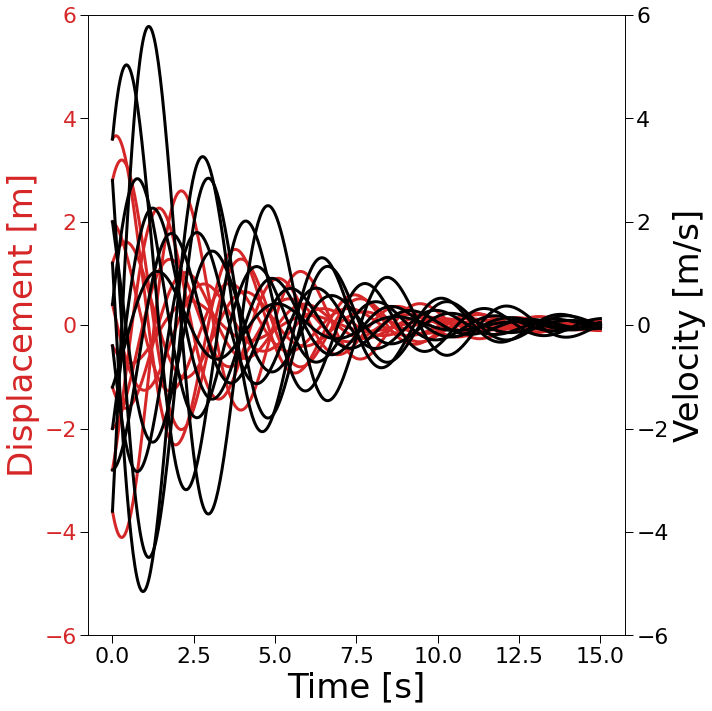

In [13]:
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()  # instantiate a second axes that shares the same x-axis
for iSample in range(n_test):
    y0         = y0MatTest[iSample,:]
    print('y0 = ', y0)
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    color = 'tab:red'
    ax1.plot(output.t, output.y[0,:], color=color)

    color = 'k'
    ax2.plot(output.t, output.y[1,:], color=color)
    
    ySourceTemp = np.zeros_like(output.y)
    for it in range(Nt):
        ySourceTemp[:,it] = fOrig_Source(output.t, output.y[:,it])

    if (iSample == 0):
        tMatTest    = tMatTemp
        uMatTest    = uMatTemp
        yMatTest    = output.y.T 
        ySourceTest = ySourceTemp.T
    else:
        tMatTest    = np.concatenate((tMatTest,    tMatTemp), axis=0)
        uMatTest    = np.concatenate((uMatTest,    uMatTemp), axis=0)
        yMatTest    = np.concatenate((yMatTest,    output.y.T), axis=0)
        ySourceTest = np.concatenate((ySourceTest, ySourceTemp.T), axis=0)
        
    Header   = 't,x,v'
    FileName = OutputDir+'/test/ext/y.csv.'+str(iSample+1)
    np.savetxt(FileName, np.concatenate((tMatTemp,output.y.T), axis=1), delimiter=',', header=Header, comments='')
        
        
color = 'tab:red'
ax1.set_xlabel('Time [s]', size=34)
ax1.set_ylabel('Displacement [m]', color=color, size=34)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-6.,6.])

color = 'k'
ax2.set_ylabel('Velocity [m/s]', color=color, size=34)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([-6.,6.])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (FigDir):
    plt.savefig(FigDir+'/MSD_TestDynamics.eps', format='eps', bbox_inches='tight')

## Writing Test Data

In [12]:
TestDir  = OutputDir+'/test/ext/'

Header   = 't,x,v'
FileName = TestDir+'/Input.csv'
np.savetxt(FileName, np.concatenate((tMatTest,uMatTest), axis=1), delimiter=',', header=Header, comments='')
        
Header   = 't,x,v'
FileName = TestDir+'/Output.csv'
np.savetxt(FileName, np.concatenate((tMatTest,yMatTest), axis=1), delimiter=',', header=Header, comments='')

Header   = 't,dx,dv'
FileName = TestDir+'/dOutput.csv'
np.savetxt(FileName, np.concatenate((tMatTest,ySourceTest), axis=1), delimiter=',', header=Header, comments='')